# Setup Weight and Bias

In [1]:
!wandb login

wandb: Currently logged in as: feicccccccc (use `wandb login --relogin` to force relogin)


# Start a new run

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.nn import functional as F
from torch import nn
from torch.utils.data import DataLoader, random_split

from torchvision.datasets import MNIST
from torchvision import transforms

# Get fast MNIST download
MNIST.mirrors = [mirror for mirror in MNIST.mirrors if not mirror.startswith("http://yann.lecun.com")]

Import the necessary library from
- PyTorch
- Torchvision for the MNIST dataset

In [3]:
import pytorch_lightning as pl
import torchmetrics
from torchmetrics import Accuracy

pl.seed_everything(hash("setting random seeds") % 2**32 - 1)

Global seed set to 2916376720


2916376720

Now import the Weight & Bias Logger

In [4]:
import wandb
from pytorch_lightning.loggers import WandbLogger

# Should already login using the terminal command
wandb.login()

wandb: Currently logged in as: feicccccccc (use `wandb login --relogin` to force relogin)


True

In [ ]:
# seed everything
pl.seed_everything(0)

# Build the model with PyTorch Lightning

In [5]:
class LitMLP(pl.LightningModule):

    def __init__(self, 
                 in_dims, 
                 n_classes=10, 
                 n_layer_1=128, 
                 n_layer_2=256, 
                 lr=1e-4):
        
        super().__init__()
        
        # Define the Layer module used in the network
        
        # we flatten the input Tensors and pass them through an MLP
        self.layer_1 = nn.Linear(np.prod(in_dims), n_layer_1)
        self.layer_2 = nn.Linear(n_layer_1, n_layer_2)
        self.layer_3 = nn.Linear(n_layer_2, n_classes)

        # log hyperparameters
        # Save all arg in __init__
        self.save_hyperparameters()

        # compute the accuracy -- no need to roll your own!
        self.train_acc = Accuracy()
        self.valid_acc = Accuracy()
        self.test_acc = Accuracy()

    def forward(self, x):
        
        batch_size, *dims = x.size()

        x = x.view(batch_size, -1)

        x = F.relu(self.layer_1(x))
        x = F.relu(self.layer_2(x))
        x = self.layer_3(x)
        
        x = F.log_softmax(x, dim=1)

        return x

    def loss(self, xs, ys):
        logits = self.forward(xs)
        loss = F.nll_loss(logits, ys)  # Negative log-liklihood loss nil_loss
        return logits, loss
    
    
    # Training step to compute loss
    # == Remember to log the metric here ==
    def training_step(self, batch, batch_idx):
        xs, ys = batch
        logits, loss = self.loss(xs, ys)
        preds = torch.argmax(logits, 1)

        # logging metrics we calculated by hand
        self.log('train/loss', loss, on_epoch=True)
        # logging a pl.Metric
        self.train_acc(preds, ys)
        self.log('train/acc', self.train_acc, on_epoch=True)

        return loss
    
    def test_step(self, batch, batch_idx):
        xs, ys = batch
        logits, loss = self.loss(xs, ys)
        preds = torch.argmax(logits, 1)

        self.test_acc(preds, ys)
        self.log("test/loss_epoch", loss, on_step=False, on_epoch=True)
        self.log("test/acc_epoch", self.test_acc, on_step=False, on_epoch=True)
        
    # At the end of the training
    def test_epoch_end(self, test_step_outputs):  # args are defined as part of pl API
        dummy_input = torch.zeros(self.hparams["in_dims"], device=self.device)
        model_filename = "model_final.onnx"
        torch.onnx.export(self, dummy_input, model_filename, opset_version=11)
        wandb.save(model_filename)
    
    # Validation step, note here we return the logiys instead of the loss
    def validation_step(self, batch, batch_idx):
        xs, ys = batch
        logits, loss = self.loss(xs, ys)
        preds = torch.argmax(logits, 1)
        self.valid_acc(preds, ys)

        self.log("valid/loss_epoch", loss)  # default on val/test is on_epoch only
        self.log('valid/acc_epoch', self.valid_acc)

        return logits

    def validation_epoch_end(self, validation_step_outputs):
        dummy_input = torch.zeros(self.hparams["in_dims"], device=self.device)
        model_filename = f"model_{str(self.global_step).zfill(5)}.onnx"
        torch.onnx.export(self, dummy_input, model_filename, opset_version=11)
        wandb.save(model_filename)

        flattened_logits = torch.flatten(torch.cat(validation_step_outputs))
        self.logger.experiment.log(
            {"valid/logits": wandb.Histogram(flattened_logits.to("cpu")),
             "global_step": self.global_step})

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.hparams["lr"])

# Create pl callback for tracking difficult training data

In [6]:
# Callback class from pl, we will include it in the trainer

class ImagePredictionLogger(pl.Callback):
    def __init__(self, val_samples, num_samples=32):
        super().__init__()
        self.val_imgs, self.val_labels = val_samples
        self.val_imgs = self.val_imgs[:num_samples]
        self.val_labels = self.val_labels[:num_samples]
          
    def on_validation_epoch_end(self, trainer, pl_module):
        val_imgs = self.val_imgs.to(device=pl_module.device)

        logits = pl_module(val_imgs)
        preds = torch.argmax(logits, 1)

        trainer.logger.experiment.log({
            "examples": [wandb.Image(x, caption=f"Pred:{pred}, Label:{y}") 
                            for x, pred, y in zip(val_imgs, preds, self.val_labels)],
            "global_step": trainer.global_step
            })

# Generate the DataModule from pl

In [7]:
class MNISTDataModule(pl.LightningDataModule):

    def __init__(self, data_dir='./data', batch_size=512):
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,))])

    def prepare_data(self):
        # download data, train then test
        MNIST(self.data_dir, train=True, download=True)
        MNIST(self.data_dir, train=False, download=True)

    def setup(self, stage=None):

        # we set up only relevant datasets when stage is specified
        if stage == 'fit' or stage is None:
            mnist = MNIST(self.data_dir, train=True, transform=self.transform)
            self.mnist_train, self.mnist_val = random_split(mnist, [55000, 5000])
        if stage == 'test' or stage is None:
            self.mnist_test = MNIST(self.data_dir, train=False, transform=self.transform)

    # we define a separate DataLoader for each of train/val/test
    def train_dataloader(self):
        mnist_train = DataLoader(self.mnist_train, batch_size=self.batch_size)
        return mnist_train

    def val_dataloader(self):
        mnist_val = DataLoader(self.mnist_val, batch_size=1self.batch_size)
        return mnist_val

    def test_dataloader(self):
        mnist_test = DataLoader(self.mnist_test, batch_size=10 * self.batch_size)
        return mnist_test

In [8]:
# setup data
mnist = MNISTDataModule()
mnist.prepare_data()
mnist.setup()

In [9]:
# grab samples to log predictions on
samples = next(iter(mnist.val_dataloader()))

Label = 5


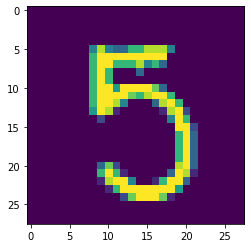

In [10]:
img_idx = 2
plt.imshow(samples[0][img_idx][0, :])
print("Label = {}".format(samples[1][img_idx]))

# Create the trainer and the wandb logger

In [11]:
wandb_logger = WandbLogger(project="test-wandb-pl-mnist")

In [12]:
trainer = pl.Trainer(
    logger=wandb_logger,    # W&B integration
    log_every_n_steps=50,   # set the logging frequency
    gpus=-1,                # use all GPUs
    max_epochs=5,           # number of epochs
    deterministic=True,     # keep it deterministic
    callbacks=[ImagePredictionLogger(samples)] # see Callbacks section
    )

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


# Train

In [13]:
# setup model
model = LitMLP(in_dims=(1, 28, 28))

# fit the model
trainer.fit(model, mnist)

# evaluate the model on a test set
trainer.test(datamodule=mnist,
             ckpt_path=None)  # uses last-saved model

wandb.finish()

/home/fei/miniconda3/envs/test_wandb/lib/python3.9/site-packages/pytorch_lightning/core/datamodule.py:423: LightningDeprecationWarning: DataModule.setup has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.setup.
  rank_zero_deprecation(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



  | Name      | Type     | Params
---------------------------------------
0 | layer_1   | Linear   | 100 K 
1 | layer_2   | Linear   | 33.0 K
2 | layer_3   | Linear   | 2.6 K 
3 | train_acc | Accuracy | 0     
4 | valid_acc | Accuracy | 0     
5 | test_acc  | Accuracy | 0     
---------------------------------------
136 K     Trainable params
0         Non-trainable params
136 K     Total params
0.544     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

/home/fei/miniconda3/envs/test_wandb/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:105: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
Global seed set to 2916376720
/home/fei/miniconda3/envs/test_wandb/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:105: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/fei/miniconda3/envs/test_wandb/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:105: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test/acc_epoch': 0.9262999892234802, 'test/loss_epoch': 0.2528951168060303}
--------------------------------------------------------------------------------


epoch,▁▁▁▁▃▃▃▃▅▅▅▅▆▆▆▆█████
global_step,▁▁▂▂▄▄▅▅▇▇██
test/acc_epoch,▁
test/loss_epoch,▁
train/acc_epoch,▁▇▇██
train/acc_step,▁▅▆▇▆▇▇▇██
train/loss_epoch,█▂▁▁▁
train/loss_step,█▃▂▂▂▁▁▁▁▁
trainer/global_step,▁▂▂▂▂▂▂▃▃▃▃▃▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇███
valid/acc_epoch,▁▅▇▇█
valid/loss_epoch,█▃▂▁▁


# Check wandb WebApp for the Dashboard